# FashionMNIST

<img src="https://emiliendupont.github.io/imgs/mnist-chicken/mnist-and-fashion-examples.png">

Мы будем работать с картинками одежды (чёрно-белыми, 28 на 28). По входной картинке нужно предсказать тип одежды на 10 классов.

In [ ]:
# установим последнюю версию wandb
!pip install -q --upgrade wandb

In [ ]:
import wandb
wandb.login()

True

In [ ]:
import os
import wandb # для логирования

import numpy as np
import random
from tqdm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim # для оптимизаторов
from torchvision import datasets # для данных
import torchvision.transforms as transforms # для преобразований тензоров

import matplotlib.pyplot as plt
import torchvision
from torch.autograd import Variable

In [ ]:
# Зафиксируем seed для воспроизводимости

def seed_everything(seed):
    random.seed(seed) # фиксируем генератор случайных чисел
    os.environ['PYTHONHASHSEED'] = str(seed) # фиксируем заполнения хешей
    np.random.seed(seed) # фиксируем генератор случайных чисел numpy
    torch.manual_seed(seed) # фиксируем генератор случайных чисел pytorch
    torch.cuda.manual_seed(seed) # фиксируем генератор случайных чисел для GPU

Выпишем все классы для последующего использования. 

In [ ]:
class CFG:

# Задаем параметры нашего эксперимента

  api = "b395e726c4c8c131c415a8b72789f43fd33a4c56"# вписать свой API Wandb  (взято с сайта https://wandb.ai/authorize)
  project = "mnist_fashion_first"# вписать название эксперимента, который предварительно надо создать в Wandb
  entity = "kledjer"# ввести свой логин

  num_epochs = 10 # количество эпох
  train_batch_size = 64 # размер батча обучающей выборки
  test_batch_size = 512 # размер батча тестовой выборки
  num_workers = 2 # количество активных процессов на загрузку данных
  lr = 0.001 # learning_rate
  seed = 2022 # для функции воспроизводимости
  wandb = False # флаг использования Wandb (выключила, потому что с ним вылезала ошибка)


In [ ]:
# функция перевода класса конфигурации в словарь

def class2dict(f):
  return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

Обратим внимание, что датасет поменялся, а значит поменлись среднее и стандартное отклонение, их необходимо посмотреть на официальной страничке датасета [ссылка](https://boscoj2008.github.io/customCNN/).

Для начала нам необходимо нормализовать данные, чтобы в дальнейшем мы могли с ними работать и не было проблем при сравнении метрик и построении графиков (в том числе, корреляция) 

В соответствии с ссылкой, предоставленной выше мы имеем, что mean = 0.2859;  std = 0.3530, наше преобразование будет иметь следующий вид:

In [ ]:
# будем загружать картинки, сразу преобразуя их в тензор и нормализуя

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.2859,), (0.3530,))])

Загружаем данные.

In [ ]:
#используя прописанную выше формулу преобразуем наши данные, нормализця их по mean и std 
train_data = datasets.FashionMNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.FashionMNIST(root='data', train=False,
                                  download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=CFG.train_batch_size,
                                          shuffle=True, num_workers=CFG.num_workers, pin_memory=True)

test_loader = torch.utils.data.DataLoader(test_data, batch_size=CFG.test_batch_size,
                                         shuffle=False, num_workers=CFG.num_workers, pin_memory=True)

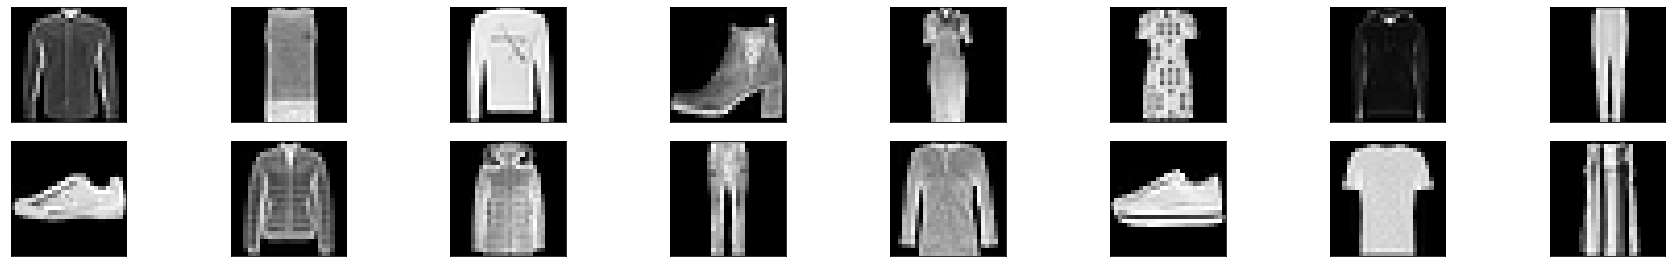

In [ ]:
# отрисуем несколько картинок

dataiter = iter(train_loader)
images, labels = next(dataiter)
images = images.numpy()

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
  plt.subplot(2, 8, idx+1)  #прописываем значения для выводимых картинок 2 - кол-во строк, 8 - кол-во значений в одной строке) 
  plt.tight_layout()  # добавлем отступы между графиками
  plt.imshow(images[idx][0], cmap='gray')   #из цветов оставляем только серый, для обратной шкалы серого можно взять cmap='gray_r'
  plt.xticks([])
  plt.yticks([])

In [ ]:
print(f"image tensor: {images.shape}")   #возвращает высоту, ширину и каналы
print(f"class labels: {labels}")

image tensor: (64, 1, 28, 28)
class labels: tensor([6, 0, 2, 9, 3, 3, 2, 1, 7, 4, 4, 1, 6, 7, 0, 6, 3, 0, 8, 8, 1, 0, 9, 7,
        8, 5, 9, 3, 7, 2, 5, 4, 0, 9, 6, 8, 4, 1, 0, 5, 2, 3, 1, 9, 3, 8, 9, 4,
        7, 7, 5, 7, 0, 7, 1, 6, 3, 3, 8, 0, 6, 3, 0, 3])


Создаем полносвязаннную нейронную сеть. 

In [ ]:
class My_Net(nn.Module): # наследуемся от класса nn.Module
    def __init__(self):
        super().__init__() # super class constructor
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=(5,5))   # слой 2д свертки
        self.batchN1 = nn.BatchNorm2d(num_features=6)   #используется для ускорения обучения
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=(5,5))  #слой свертки для второго слоя
        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.batchN2 = nn.BatchNorm1d(num_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60) #призводим линейное преобразования
        self.out = nn.Linear(in_features=60, out_features=10)
        
        
        
    def forward(self, out): # реализуем через метод forward 
        
        # скрытый слой 1
        out = self.conv1(out)
        out = F.max_pool2d(input=out, kernel_size=2, stride=2)
        out = F.relu(out)
        out = self.batchN1(out)
        
        # скрытый слой 2
        out = self.conv2(out)
        out = F.max_pool2d(input=out, kernel_size=2, stride=2)
        out = F.relu(out)
        
        # перобразуем массив в одномерный вектор
        out = out.reshape(-1, 12*4*4) #меняем форму массива данных 
        out = self.fc1(out) #запускаем вычисления внутри слоя 1
        out = F.relu(out) #функция активации
        out = self.batchN2(out) 
        out = self.fc2(out)
        out = F.relu(out)
        
        # выходная характеристика
        out = self.out(out)
        
        return out        

In [ ]:
#посмотрим на структуру модели
model = My_Net()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
print(model) # посмотрим на нашу модель

My_Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (batchN1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=192, out_features=120, bias=True)
  (batchN2): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=120, out_features=60, bias=True)
  (out): Linear(in_features=60, out_features=10, bias=True)
)


In [ ]:
# функция потерь (cross-entropy) для 10 классов
criterion = nn.CrossEntropyLoss()

# SGD (классический) со скоростью обучения (learning rate) = 0.01
optimizer = torch.optim.SGD(params=model.parameters(),
                           lr=0.01)

In [ ]:
# функция обучения модели
def train(model, device, train_loader, optimizer, criterion, epoch, WANDB):
    model.train()  # обязательно переводим в режим обучения
    test_loss = 0
    correct = 0
    
    n_ex = len(train_loader)
    
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=n_ex):
        data, target = data.to(device), target.to(device) # переводим картинки и таргеты на GPU
        # обнуляем градиенты!
        optimizer.zero_grad()
        # прямой проход
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item() # определяем корректность предсказания
        train_loss = criterion(output, target) # считаем значение функции потерь
        # обратный проход
        train_loss.backward()
        # делаем градиентный шаг оптимизатором
        optimizer.step()
        # считаем метрики и лосс
    tqdm.write('\nTrain set: Average loss: {:.4f}, Accuracy: {:.0f}%'.format(
        train_loss, 100. * correct / len(train_loader.dataset)))
    
    if WANDB:
        wandb.log({'train_loss': train_loss,
                   'train_accuracy': correct / len(train_loader.dataset)})

In [ ]:
# функция тестирования
def test(model, device, test_loader, criterion, WANDB):
    model.eval() # переводем модель в режим инференса
    test_loss = 0
    correct = 0
    # показываем, что обученич нет и градиенты не обновляются
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss = criterion(output, target) # считаем значение функции потерь
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            # считаем метрики
    tqdm.write('Test set: Average loss: {:.4f}, Accuracy: {:.0f}%'.format(
        test_loss, 100. * correct / len(test_loader.dataset)))
    
    if WANDB:
        wandb.log({'test_loss': test_loss,
                   'test_accuracy': correct / len(test_loader.dataset)})

In [ ]:
# основная функция для экспериментов
def main(model):
    # настраиваем окружение для wandb
    if CFG.wandb:
        os.environ["WANDB_API_KEY"] = CFG.api
        wandb.init(project=CFG.project, entity=CFG.entity, reinit=True, config=class2dict(CFG))
  
    use_cuda = torch.cuda.is_available() # проверяем доступность GPU 

    seed_everything(CFG.seed) # фиксируем сиды

    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') # выделили устройство 
    
    if CFG.wandb:
        wandb.watch(model, log='all') # логируем все (метрики, лоссы, градиенты)

    for epoch in range(1, CFG.num_epochs + 1): # цикл на эпохи
        print('\nEpoch:', epoch)
        train(model, device, train_loader, optimizer, criterion, epoch, CFG.wandb)
        test(model, device, test_loader, criterion, CFG.wandb)
    print('Training is end!')

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
print(gpu_info)

Wed Mar  1 17:52:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    27W /  70W |   1167MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Запускаем обучение. Цель - получить на тесте значение accuracy не менее 98%.

In [ ]:
main(model)


Epoch: 1


100%|██████████| 938/938 [00:19<00:00, 47.44it/s]


Train set: Average loss: 0.6468, Accuracy: 76%


Test set: Average loss: 0.3961, Accuracy: 83%

Epoch: 2


100%|██████████| 938/938 [00:18<00:00, 51.23it/s]


Train set: Average loss: 0.3200, Accuracy: 85%


Test set: Average loss: 0.3348, Accuracy: 86%

Epoch: 3


100%|██████████| 938/938 [00:18<00:00, 49.68it/s]


Train set: Average loss: 0.3027, Accuracy: 87%


Test set: Average loss: 0.2807, Accuracy: 87%

Epoch: 4


100%|██████████| 938/938 [00:18<00:00, 49.65it/s]


Train set: Average loss: 0.5506, Accuracy: 88%


Test set: Average loss: 0.2704, Accuracy: 87%

Epoch: 5


100%|██████████| 938/938 [00:18<00:00, 51.42it/s]


Train set: Average loss: 0.5174, Accuracy: 88%


Test set: Average loss: 0.2534, Accuracy: 88%

Epoch: 6


100%|██████████| 938/938 [00:19<00:00, 48.93it/s]


Train set: Average loss: 0.2502, Accuracy: 89%


Test set: Average loss: 0.2329, Accuracy: 89%

Epoch: 7


100%|██████████| 938/938 [00:18<00:00, 51.59it/s]


Train set: Average loss: 0.2788, Accuracy: 90%


Test set: Average loss: 0.2404, Accuracy: 88%

Epoch: 8


100%|██████████| 938/938 [00:18<00:00, 51.59it/s]


Train set: Average loss: 0.2968, Accuracy: 90%


Test set: Average loss: 0.2479, Accuracy: 89%

Epoch: 9


100%|██████████| 938/938 [00:20<00:00, 45.22it/s]


Train set: Average loss: 0.2430, Accuracy: 90%


Test set: Average loss: 0.2395, Accuracy: 89%

Epoch: 10


100%|██████████| 938/938 [00:18<00:00, 51.54it/s]


Train set: Average loss: 0.4020, Accuracy: 90%


Test set: Average loss: 0.2346, Accuracy: 89%
Training is end!


Пробуем другие оптимизаторы.

Может стоить добавить еще пару слоев? Как уже говорилось ранее, deep learning - это пространство для экспериментов и творчества. Дерзайте!